In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as colors
import numpy as np 
import numpy.linalg as npl
from random import choices, seed
from pathlib import Path
import os
import sys
os.chdir('../')
from gen_geom import geom
from gen_obs import obs
obs = obs()
msh = geom()
domaine_size = msh.y.size * msh.x.size
presence_threshold = 0.065

path_case = os.getcwd()
path_data = path_case + '/data'

In [2]:
import pherosensor

from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation, Source
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

from source_localization.cost import Cost
from source_localization.control import Control
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation
from source_localization.obs import Obs

from utils.plot_ctrl import plot_ctrl
from utils.superlevel_set import *


In [3]:
colors_dic = {
    'no reg':                '#377eb8',   #'blue'    
    'reg LASSO':             '#f781bf',   #'pink'  
    'reg group LASSO':       '#dede00',   #'yellow'  
} 

In [4]:
def presence_prediction(S):
    presence = [
         superlevel_set(presence_threshold, S[i,:,:]) for i,_ in enumerate(msh.t_array)
     ]
    return presence

def compute_proportion(presence_pred_vs_t, presence_truth_vs_t, msh): 
    miss_rate = np.ones_like(msh.t_array)
    false_discovery_rate = np.ones_like(msh.t_array)
    for i, (presence_pred, presence_truth) in enumerate(zip(presence_pred_vs_t, presence_truth_vs_t)):
        false_presence_pred = presence_pred & (~ presence_truth)
        false_absence_pred = (~ presence_pred) & presence_truth
        volume_false_presence_pred = volume(false_presence_pred, msh.mass_cell*msh.dt)
        volume_false_absence_pred = volume(false_absence_pred, msh.mass_cell*msh.dt)
        volume_presence_truth = volume(presence_truth, msh.mass_cell*msh.dt)
        volume_presence_pred = volume(presence_pred, msh.mass_cell*msh.dt)
        miss_rate[i] = volume_false_absence_pred / volume_presence_truth
        false_discovery_rate[i] = volume_false_presence_pred / volume_presence_pred     
    return miss_rate, false_discovery_rate

# Load and plot the output

## Load the target

In [5]:
S_value = np.load(Path(path_data) / 'S_target.npy')
ctrl_target = Control(Source(msh, S_value, t=msh.t_array), msh)
ctrl_target.value = np.copy(ctrl_target.background_value)
true_presence = presence_prediction(S_value)
target = {
    'label': 'target', 
    'ctrl': ctrl_target, 
    'ls': 'k', 
    'prediction of presence': true_presence
}

## Load the output with no reg

In [6]:
path_output = path_case + '/output_noreg'
S_o_no_reg = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_no_reg = Control(Source(msh, S_o_no_reg, t=msh.t_array), msh)
ctrl_no_reg.value = np.copy(ctrl_no_reg.background_value)
RMSE_liste_no_reg = [npl.norm(S_o_no_reg[i,:,:]-S_value[i,:,:]) / np.sqrt(domaine_size) for i,_ in enumerate(msh.t_array)]
RMSE_no_reg = np.array(RMSE_liste_no_reg)
prediction_presence_no_reg = presence_prediction(S_o_no_reg)
miss_rate_no_reg, false_discovery_rate_no_reg = compute_proportion(prediction_presence_no_reg,true_presence, msh)
Linf_norm_mono_sensor_adjoint_states_noreg = np.load(Path(path_output) / 'linf_norm_one_sensor_adjoint_states.npy')

no_reg = {
    'label': 'no reg', 
    'ctrl': ctrl_no_reg, 
    'ls': colors_dic['no reg'], 
    'RMSE': RMSE_no_reg, 
    'prediction of presence': prediction_presence_no_reg, 
    'miss rate': miss_rate_no_reg,
    'false discovery rate': false_discovery_rate_no_reg, 
    "Linf norm mono sensor adjoint states" : Linf_norm_mono_sensor_adjoint_states_noreg,
    "index sort" : np.argsort(Linf_norm_mono_sensor_adjoint_states_noreg)[::-1],
}

## Load the output with LASSO reg

In [7]:
path_output = path_case + '/output_regLASSO'
S_o_reg_LASSO = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_reg_LASSO = Control(Source(msh, S_o_reg_LASSO, t=msh.t_array), msh)
ctrl_reg_LASSO.value = np.copy(ctrl_reg_LASSO.background_value)
RMSE_liste_reg_LASSO = [npl.norm(S_o_reg_LASSO[i,:,:]-S_value[i,:,:]) / np.sqrt(domaine_size) for i,_ in enumerate(msh.t_array)]
RMSE_reg_LASSO = np.array(RMSE_liste_reg_LASSO)
prediction_presence_reg_LASSO = presence_prediction(S_o_reg_LASSO)
miss_rate_reg_LASSO, false_discovery_rate_reg_LASSO = compute_proportion(prediction_presence_reg_LASSO,true_presence, msh)
Linf_norm_mono_sensor_adjoint_states_reg_LASSO = np.load(Path(path_output) / 'linf_norm_one_sensor_adjoint_states.npy')

reg_LASSO = {
    'label': 'LASSO', 
    'ctrl': ctrl_reg_LASSO, 
    'ls': colors_dic['reg LASSO'], 
    'RMSE': RMSE_reg_LASSO, 
    'prediction of presence': prediction_presence_reg_LASSO,
    'miss rate': miss_rate_reg_LASSO,
    'false discovery rate': false_discovery_rate_reg_LASSO,
    "Linf norm mono sensor adjoint states" : Linf_norm_mono_sensor_adjoint_states_reg_LASSO,
    "index sort" : np.argsort(Linf_norm_mono_sensor_adjoint_states_reg_LASSO)[::-1],
}

## Load the output with group LASSO reg

In [8]:
path_output = path_case + '/output_reggroupLASSO'
S_o_reg_groupLASSO = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_reg_groupLASSO = Control(Source(msh, S_o_reg_groupLASSO, t=msh.t_array), msh)
ctrl_reg_groupLASSO.value = np.copy(ctrl_reg_groupLASSO.background_value)
RMSE_liste_reg_groupLASSO = [npl.norm(S_o_reg_groupLASSO[i,:,:]-S_value[i,:,:]) / np.sqrt(domaine_size) for i,_ in enumerate(msh.t_array)]
RMSE_reg_groupLASSO = np.array(RMSE_liste_reg_groupLASSO)
prediction_presence_reg_groupLASSO = presence_prediction(S_o_reg_groupLASSO)
miss_rate_reg_groupLASSO, false_discovery_rate_reg_groupLASSO = compute_proportion(prediction_presence_reg_groupLASSO, true_presence, msh)
Linf_norm_mono_sensor_adjoint_states_reg_groupLASSO = np.load(Path(path_output) / 'linf_norm_one_sensor_adjoint_states.npy')

reg_group_groupLASSO = {
    'label': 'group LASSO', 
    'ctrl': ctrl_reg_groupLASSO, 
    'ls': colors_dic['reg group LASSO'], 
    'RMSE': RMSE_reg_groupLASSO, 
    'prediction of presence': prediction_presence_reg_groupLASSO,
    'miss rate': miss_rate_reg_groupLASSO,
    'false discovery rate': false_discovery_rate_reg_groupLASSO,
    "Linf norm mono sensor adjoint states" : Linf_norm_mono_sensor_adjoint_states_reg_groupLASSO,
    "index sort" : np.argsort(Linf_norm_mono_sensor_adjoint_states_reg_groupLASSO)[::-1],
}

## Compare the outputs with different reg strategies

In [9]:
def plot_mean_error_comparison_vs_t(
    msh, 
    case_dict, 
    target_ctrl,
    save_flag=False, 
    save_path=None, 
    file_name=None, 
    mean_energie_vs_time=1,
    t_window = None,
    file_format='pdf',
): 
    if t_window is None: 
        t_window = [np.min(msh.t_array),np.max(msh.t_array)]
    i_tb = np.searchsorted(msh.t_array,t_window[0])
    i_te = np.searchsorted(msh.t_array,t_window[1])
    S_t = target_ctrl.value.reshape((msh.t_array.size, msh.y.size, msh.x.size))
    
    fontsize = 25
    fig, (ax_RMSE, ax_RMSE2) = plt.subplots(2,1, figsize=(20, 10), sharex=True)
    fig.subplots_adjust(hspace=0)
    for key in case_dict.keys():
        case = case_dict[key]
        
        S_o = case['ctrl'].value.reshape((msh.t_array.size, msh.y.size, msh.x.size))
        RMSE_support = np.zeros_like(msh.t_array)
        RMSE_complement_support = np.zeros_like(msh.t_array)
        for i,_ in enumerate(msh.t_array):
            support_size = S_t[i,S_t[i,:,:]!=0.].size
            complement_support_size = S_t[i,S_t[i,:,:]==0.].size
            RMSE_support[i] = npl.norm(S_o[i,S_t[i,:,:]!=0.]-S_t[i,S_t[i,:,:]!=0.]) / np.sqrt(support_size)
            RMSE_complement_support[i] = npl.norm(S_o[i,S_t[i,:,:]==0.]-S_t[i,S_t[i,:,:]==0.]) / np.sqrt(complement_support_size)

        ax_RMSE.plot(msh.t_array[i_tb:i_te], case['RMSE'][i_tb:i_te], color=case['ls'], label=case['label'])#r'on $\Omega_{supp}$')
        ax_RMSE2.plot(msh.t_array[i_tb:i_te], RMSE_support[i_tb:i_te], color=case['ls'])#, ls='--', label=r'on $\overline{\Omega}_{supp}$, '+case['label'])
        
    ax_RMSE.set_xlim(t_window[0], t_window[1])
    ax_RMSE.set_ylabel(r'$RxMSE_{tot}$', fontsize=fontsize)
    ax_RMSE.tick_params(labelsize=fontsize - 5)
    
    ax_RMSE2.set_xlim(t_window[0], t_window[1])
    ax_RMSE2.set_xlabel(r'$t$ ($s$)', fontsize=fontsize)
    ax_RMSE2.set_ylabel(r'$RxMSE_{supp}$', fontsize=fontsize)
    ax_RMSE2.tick_params(labelsize=fontsize - 5)
    
    line_RMSE, label_RMSE = ax_RMSE.get_legend_handles_labels()
    ax_RMSE.legend(line_RMSE,label_RMSE,prop={'size': fontsize},loc='upper left', ncol=4)
    
    if save_flag:
        fname = f"{file_name}."+file_format
        plt.savefig(Path(save_path) / fname, format=file_format, bbox_inches="tight")
    else :
        plt.show()

In [10]:
def plot_mulitple_ctrl_multiple_t(
    msh,
    iter_times,
    case_dict,
    ctrl_target=None,
    cmap="jet",
    map_bound=None,
    label='s',
    save_path=None,
    file_name=None,
    file_format='pdf',
    figsize=(20, 15),
    n_ligne=1
):
    
    if ctrl_target is not None:
        ctrl_target_map = ctrl_target.reshape((msh.t_array.size, msh.y.size, msh.x.size))
    else:
        ctrl_target_map = None
    
    vmin = np.inf
    vmax = -np.inf
    for index_case, key in enumerate(case_dict.keys()):
        case = case_dict[key]
        for index_time, index_t in enumerate(iter_times):  
            ctrl_current_t = case['ctrl'].value.reshape((msh.t_array.size, msh.y.size, msh.x.size))[index_t, :, :]
            vmin = np.min((vmin, np.min(ctrl_current_t)))
            vmax = np.max((vmax, np.max(ctrl_current_t)))        
        
    fontsize = 25
    unit = "g.m^{-2}.s^{-1}"
    
    nombre_col = np.int(np.ceil(len(case_dict)/n_ligne))
    nombre_ligne = np.int(len(iter_times)*n_ligne)
    nombre_temps = np.int(len(iter_times))
    fig, ax = plt.subplots(
        nombre_ligne, 
        nombre_col, 
        figsize=figsize, 
        sharex=True, 
        sharey=True
    )
    
    for index_case, key in enumerate(case_dict.keys()):
        case = case_dict[key]
        for index_time, index_t in enumerate(iter_times):
            ctrl_current_t = case['ctrl'].value.reshape((msh.t_array.size, msh.y.size, msh.x.size))[index_t, :, :]
            
            index_ligne = (index_case // (nombre_col)) * nombre_temps + index_time
            index_colonne = index_case % (nombre_col)
            
            if index_time == 0:
                title=case['label'] + f'\n\n at t = {"{:.1f}".format(msh.t_array[index_t])} s'
            else : 
                title="" + f'at t = {"{:.1f}".format(msh.t_array[index_t])} s'
                pos1 = ax[index_ligne, index_colonne].get_position() 
                pos2 = [pos1.x0, pos1.y0 + 0.015,  pos1.width, pos1.height] 
                ax[index_ligne, index_colonne].set_position(pos2) 
                
            ctrl_target_current_t = np.copy(ctrl_target_map[index_t, :, :])
            cntr = ax[index_ligne, index_colonne].contour(msh.x-np.min(msh.x), msh.y-np.min(msh.y), ctrl_target_current_t, colors='k', linestyles='dashed', levels=[np.max(ctrl_target_current_t)*0.5], linewidths=2.)
            fmt = ticker.LogFormatterMathtext()
            fmt.create_dummy_axis()
            ax[index_ligne, index_colonne].clabel(cntr, cntr.levels, inline=True, fontsize=fontsize, fmt=fmt)

            pcmesh = ax[index_ligne, index_colonne].pcolormesh(msh.x-np.min(msh.x), msh.y-np.min(msh.y), ctrl_current_t, cmap=cmap, vmin=vmin, vmax=vmax)
            
            ax[index_ligne, index_colonne].set_title(title, loc='center', fontsize=fontsize-5)
            ax[index_ligne, index_colonne].tick_params(labelsize=fontsize - 5)
            ax[index_ligne, index_colonne].set_aspect('equal', adjustable='box')

    fig.supxlabel('$x$ ($m$)', fontsize=fontsize, x=0.5, y=0.08)
    fig.supylabel('$y$ ($m$)', fontsize=fontsize, x=0.07, y=0.5)
    """
    for axis in ax[2:4, -1]:
        axis.remove()
    #cbar_ax = fig.add_axes([0.8, 0.125, 0.05, 0.35])
    """
    cbar_ax = fig.add_axes([0.92, 0.125, 0.01, 0.755])
    cbar = fig.colorbar(pcmesh, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=fontsize - 5)
    cbar.set_label('$s_a$ ($pg.m^{-2}.s^{-1}$)', rotation=270, fontsize=fontsize, labelpad=40)
    if save_path is None:
        plt.show()
    else:
        if not os.path.isdir(Path(save_path)):
            os.makedirs(Path(save_path))
        if file_name is None:
            file_name = label
        plt.savefig(Path(save_path) / f"{file_name}.{file_format}", format=file_format, bbox_inches="tight")
        plt.close('all')


In [11]:
def plot_sls_comp(
    msh, 
    case_dict, 
    i_t_list, 
    eps, 
    save_path=None, 
    file_name=None, 
    file_format='eps',
    figsize=(20, 15)
):
    
    fontsize = 25
    lines = []
    labels = []
    fig, ax = plt.subplots(2,len(i_t_list), figsize=figsize)#
    gs = ax[1, 0].get_gridspec()
    for axis in ax[1, :]:
        axis.remove()
    ax_bis = fig.add_subplot(gs[1, :])
    for key in case_dict.keys():
        case = case_dict[key]
        ctrl_xytmap = case['ctrl'].value.reshape((msh.t_array.size, msh.y.size, msh.x.size))
        for index_plot, i_t in enumerate(i_t_list):
            ctrl_map = ctrl_xytmap[i_t,:,:]
            cs = ax[0, index_plot].contour(msh.x, msh.y, ctrl_map>eps, colors=case['ls'], linestyles='dashed', levels=0, linewidths=4)
            if index_plot == 0: 
                lines += cs.legend_elements()[0]
                labels.append(case['label'])    
            #    ax[0, index_plot].legend(lines, labels, fontsize=fontsize-5)                
            ax[0, index_plot].set_xlabel("$x$ ($m$)", fontsize=fontsize)
            ax[0, index_plot].set_ylabel("$y$ ($m$)", fontsize=fontsize)
            ax[0, index_plot].set_xlim(np.min(msh.x), np.max(msh.x))
            ax[0, index_plot].set_ylim(np.min(msh.y), np.max(msh.y))
            ax[0, index_plot].set_aspect('equal', adjustable='box')
            ax[0, index_plot].tick_params(labelsize=fontsize - 5)
            title = f'at t = {"{:.2f}".format(msh.t_array[i_t])} s'
            ax[0, index_plot].set_title(title, loc='center', fontsize=fontsize)
        if not key == 'target':
            ax_bis.plot(msh.t_array, case['miss rate'], color=case['ls'])
            ax_bis.plot(msh.t_array, case['false discovery rate'], color=case['ls'], ls='dashed')
    ax_bis.plot(-1, 0.5, color='black', ls='solid', label=r'$\rho_{fa}$ miss rate')
    ax_bis.plot(-1, 0.5, color='black', ls='dashed', label=r'$\rho_{fp}$ false discovery rate')
    ax_bis.set_xlabel("$t$ ($s$)", fontsize=fontsize)
    ax_bis.set_ylabel(r"$\rho$", fontsize=fontsize)
    ax_bis.set_xlim(np.min(msh.t_array), np.max(msh.t_array))
    ax_bis.tick_params(labelsize=fontsize - 5)
    ax_bis.legend(loc='upper left', fontsize=fontsize-5)
    
    fig.legend(lines, labels, fontsize=fontsize-5, loc='upper center', ncol=5, bbox_to_anchor=(0.5, .96)) 
    if save_path is not None:
        if not os.path.isdir(Path(save_path)):
            os.makedirs(Path(save_path))
        if file_name is None:
            file_name = 'sls'
        plt.savefig(Path(save_path) / f"{file_name}.{file_format}", format=file_format, bbox_inches="tight")
        plt.close('all')

In [12]:
def plot_bump_chart(
    case_dict, 
    save_plot_path = None, 
    name_file = '', 
    file_format = 'pdf'

):
    n_case = len(case_dict.keys())
    ytick_labels = [case_dict[key]['label'] for key in case_dict.keys()]
    vmin = np.inf 
    vmax = -np.inf 
    fontsize = 25

    fig, ax_top = plt.subplots(1, 1, figsize=(26,15), sharey=True)
    for key in case_dict.keys():
        case = case_dict[key]
        linf_norm = case["Linf norm mono sensor adjoint states"][case["index sort"]]
        n_sensors = linf_norm.size
        ax_top.plot(np.arange(1,n_sensors+1), linf_norm, 'o-', color=case['ls'], label=case['label'])
        vmin = np.min((np.min(linf_norm),vmin))
        vmax = np.max((np.max(linf_norm),vmax))

    ax_top.set_yscale('log')
    ax_top.set_xlabel('sensor index', fontsize=fontsize)
    ax_top.set_ylabel('$\|\|c^*_{i,tot}\|\|_{\infty}$', fontsize=fontsize)
    ax_top.tick_params(labelsize=fontsize - 5)
    ax_top.set_ylim(0.99*vmin, 1.01*vmax)
    ax_top.set_xlim(1,n_sensors)
    ax_top.legend(fontsize=fontsize, ncol=4)
    
    plt.subplots_adjust(wspace=0, top=.76)
    if save_plot_path is None:
        plt.show()
    else: 
        plt.savefig(Path(save_plot_path) / f"{name_file}.{file_format}", format=file_format, bbox_inches="tight")

In [13]:
dic ={
    'no reg':no_reg, 
    'reg LASSO': reg_LASSO, 
    'reg group LASSO': reg_group_groupLASSO,
} 
save_plot_path = 'TO BE DEFINED'


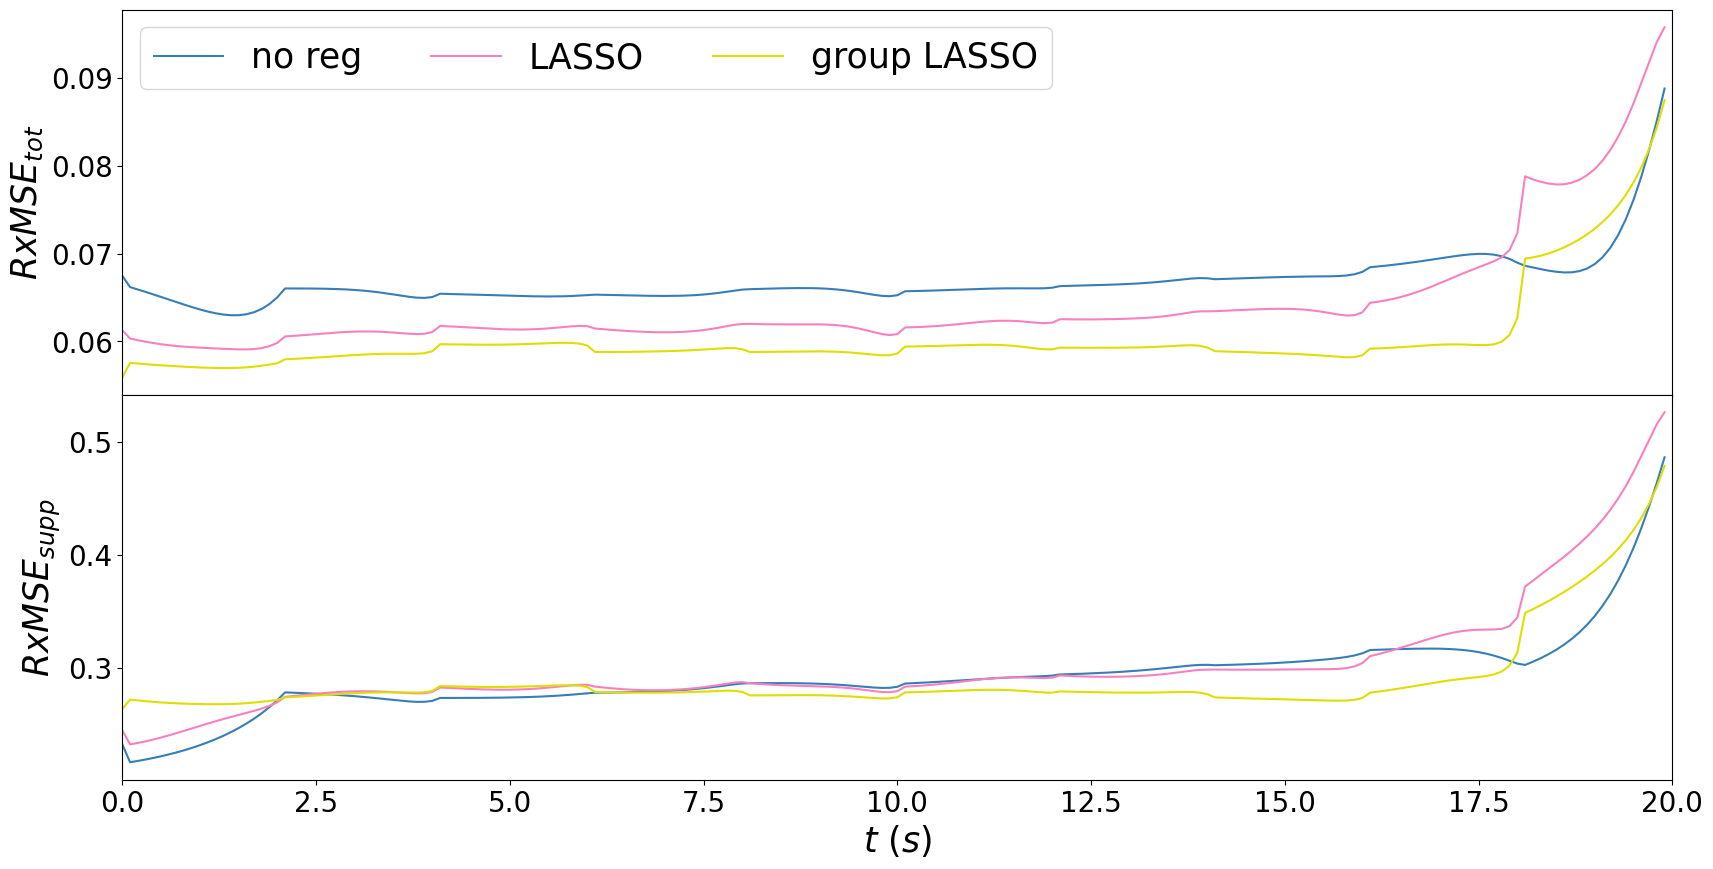

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use

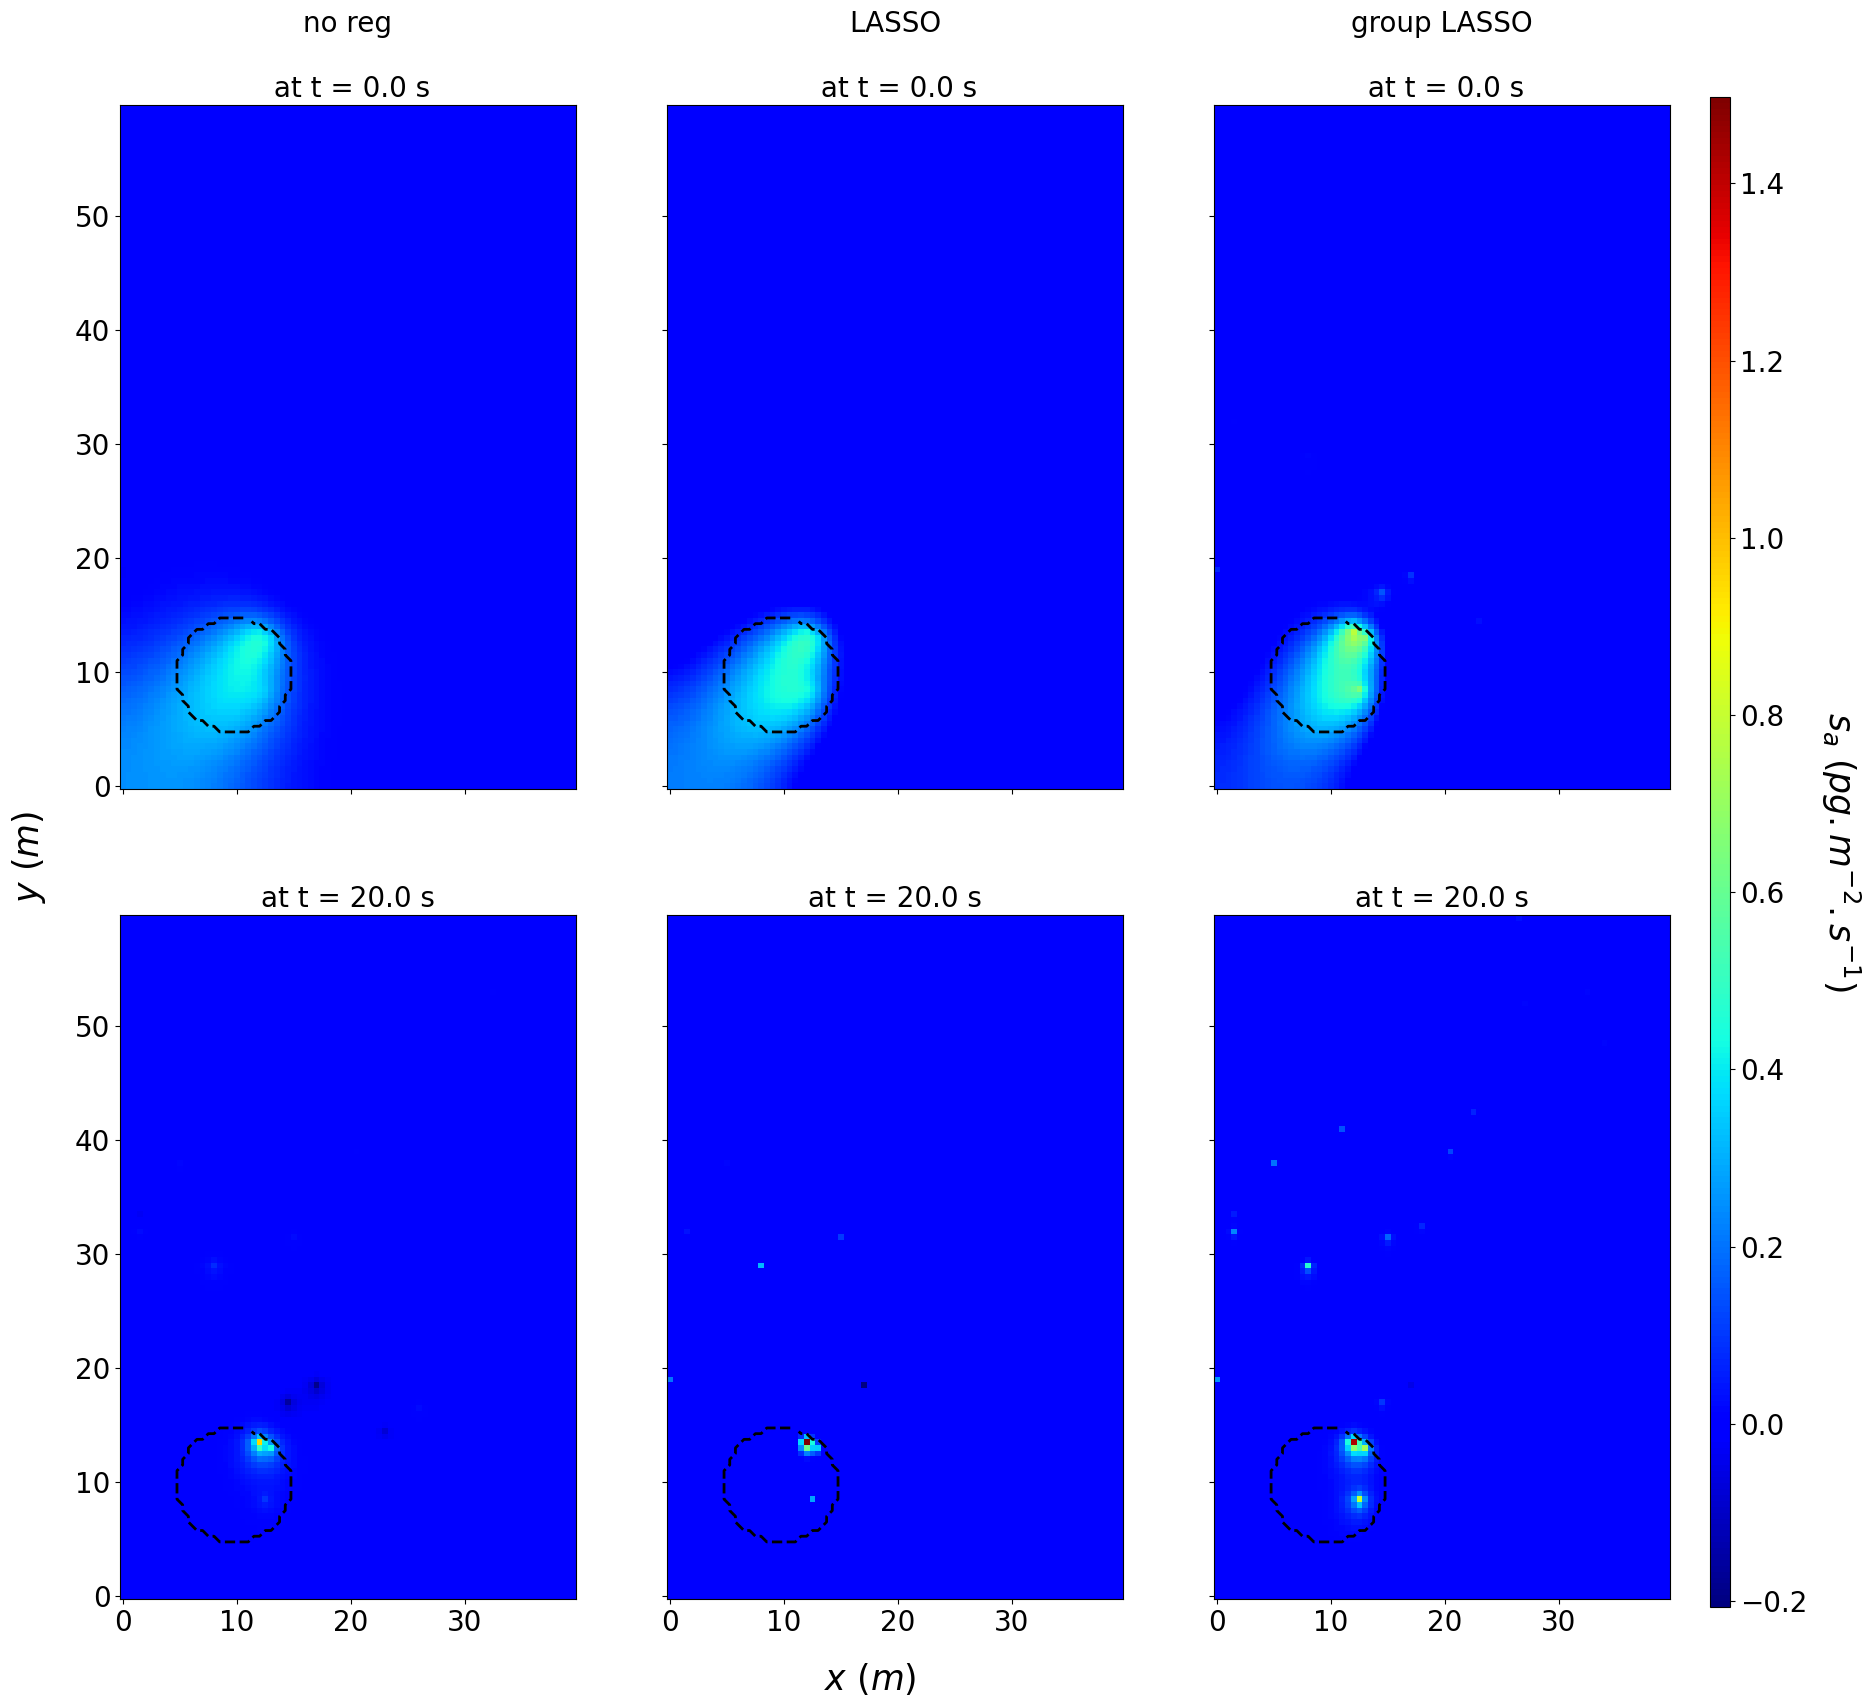

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


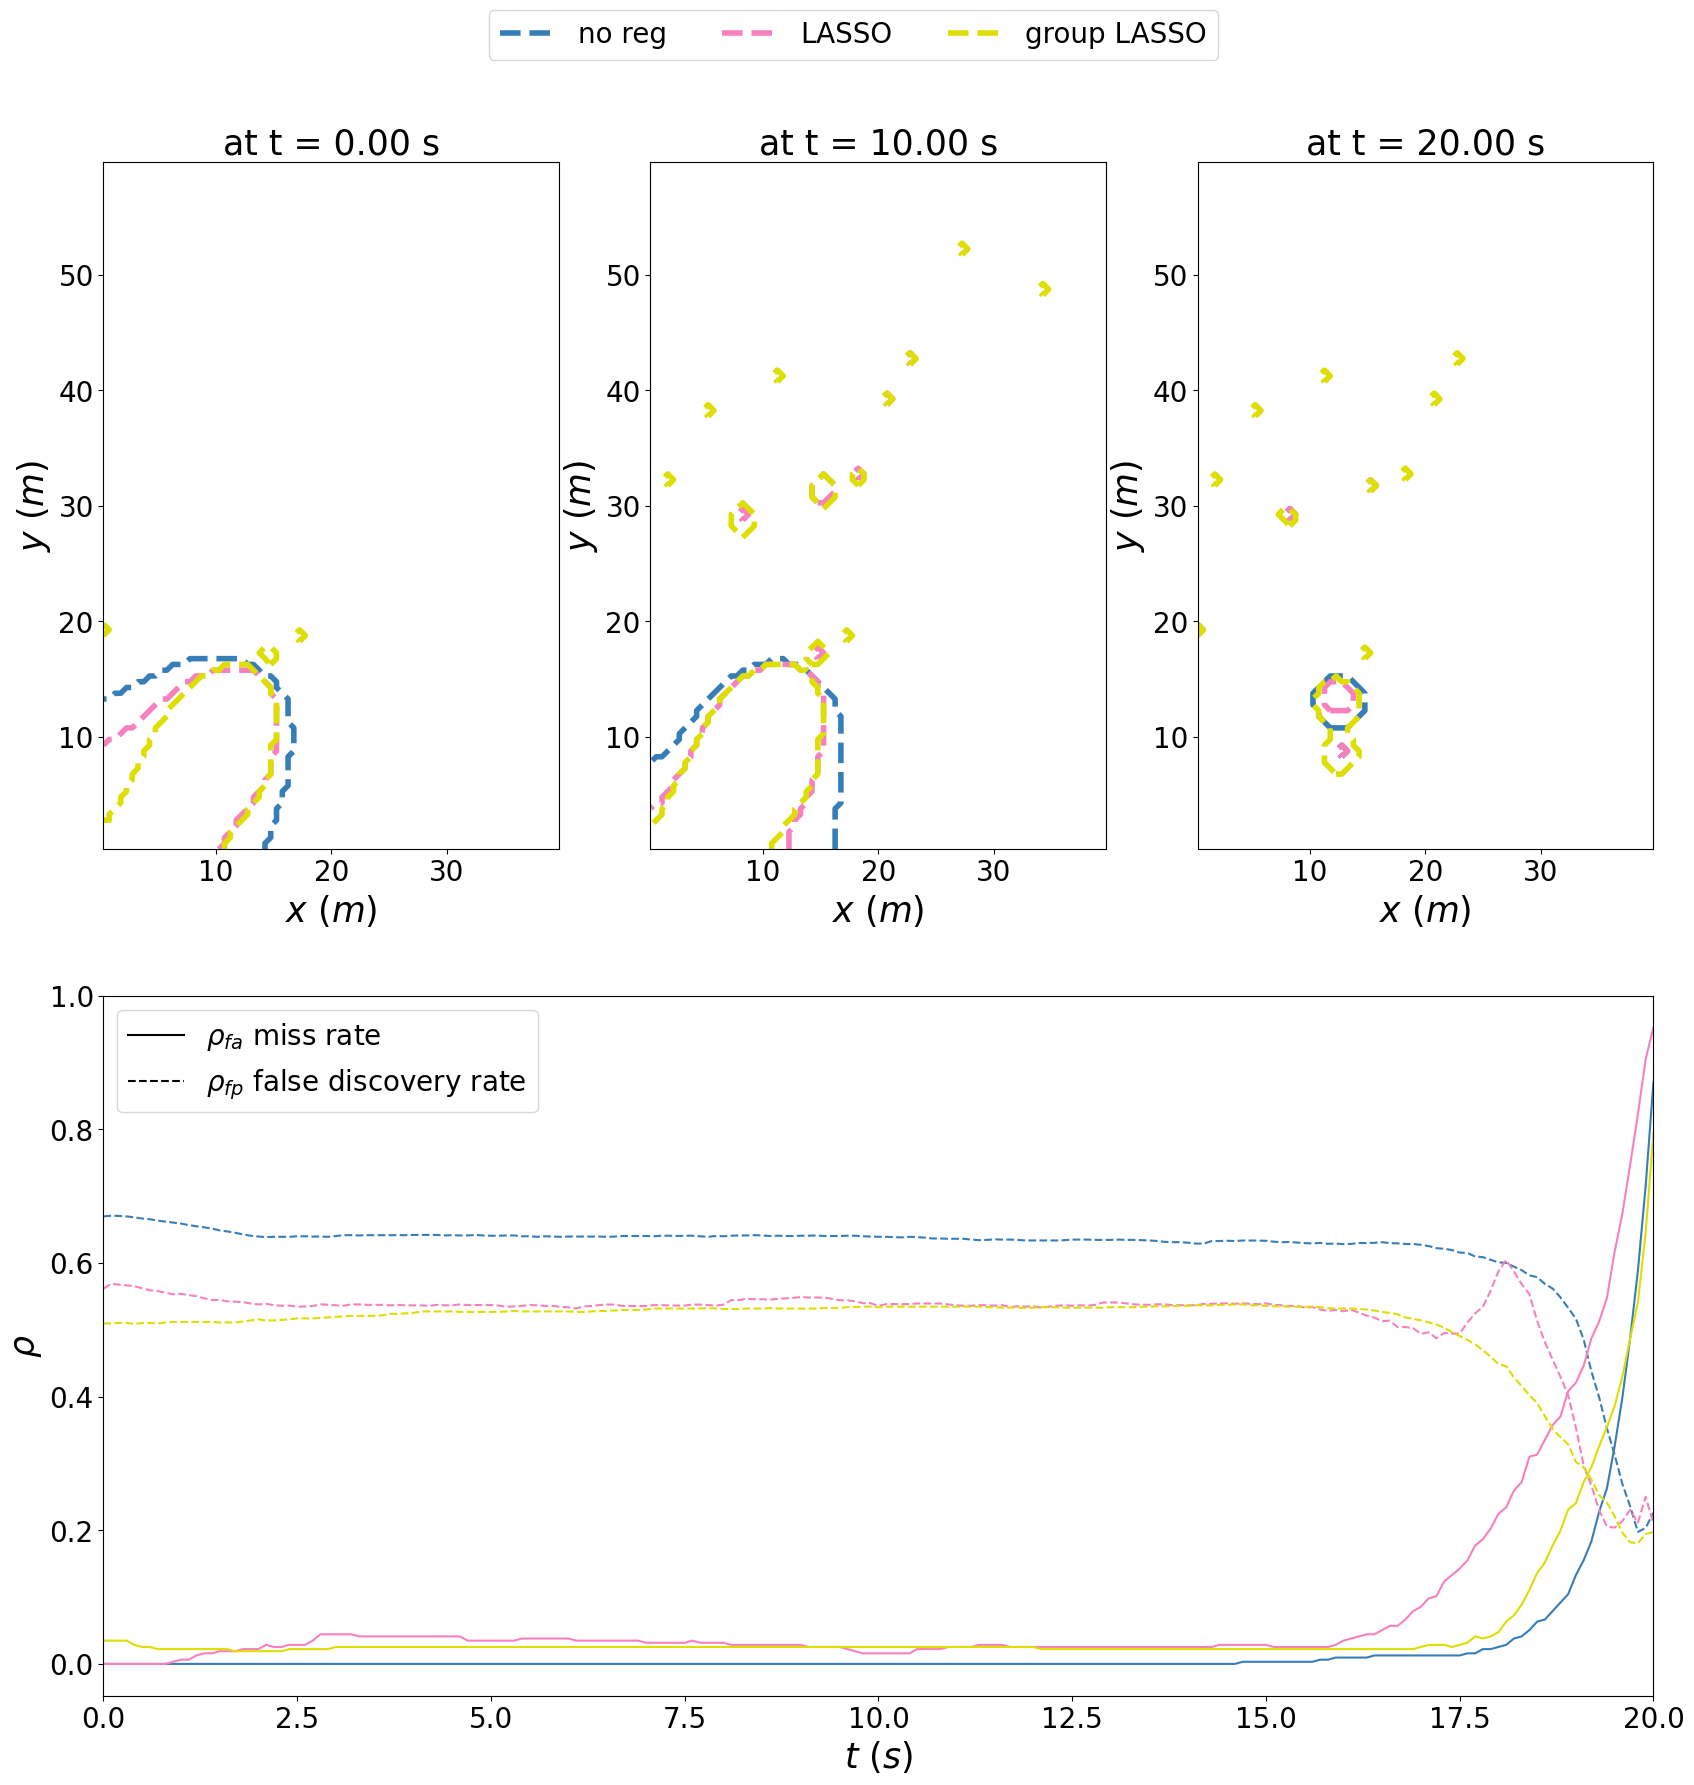

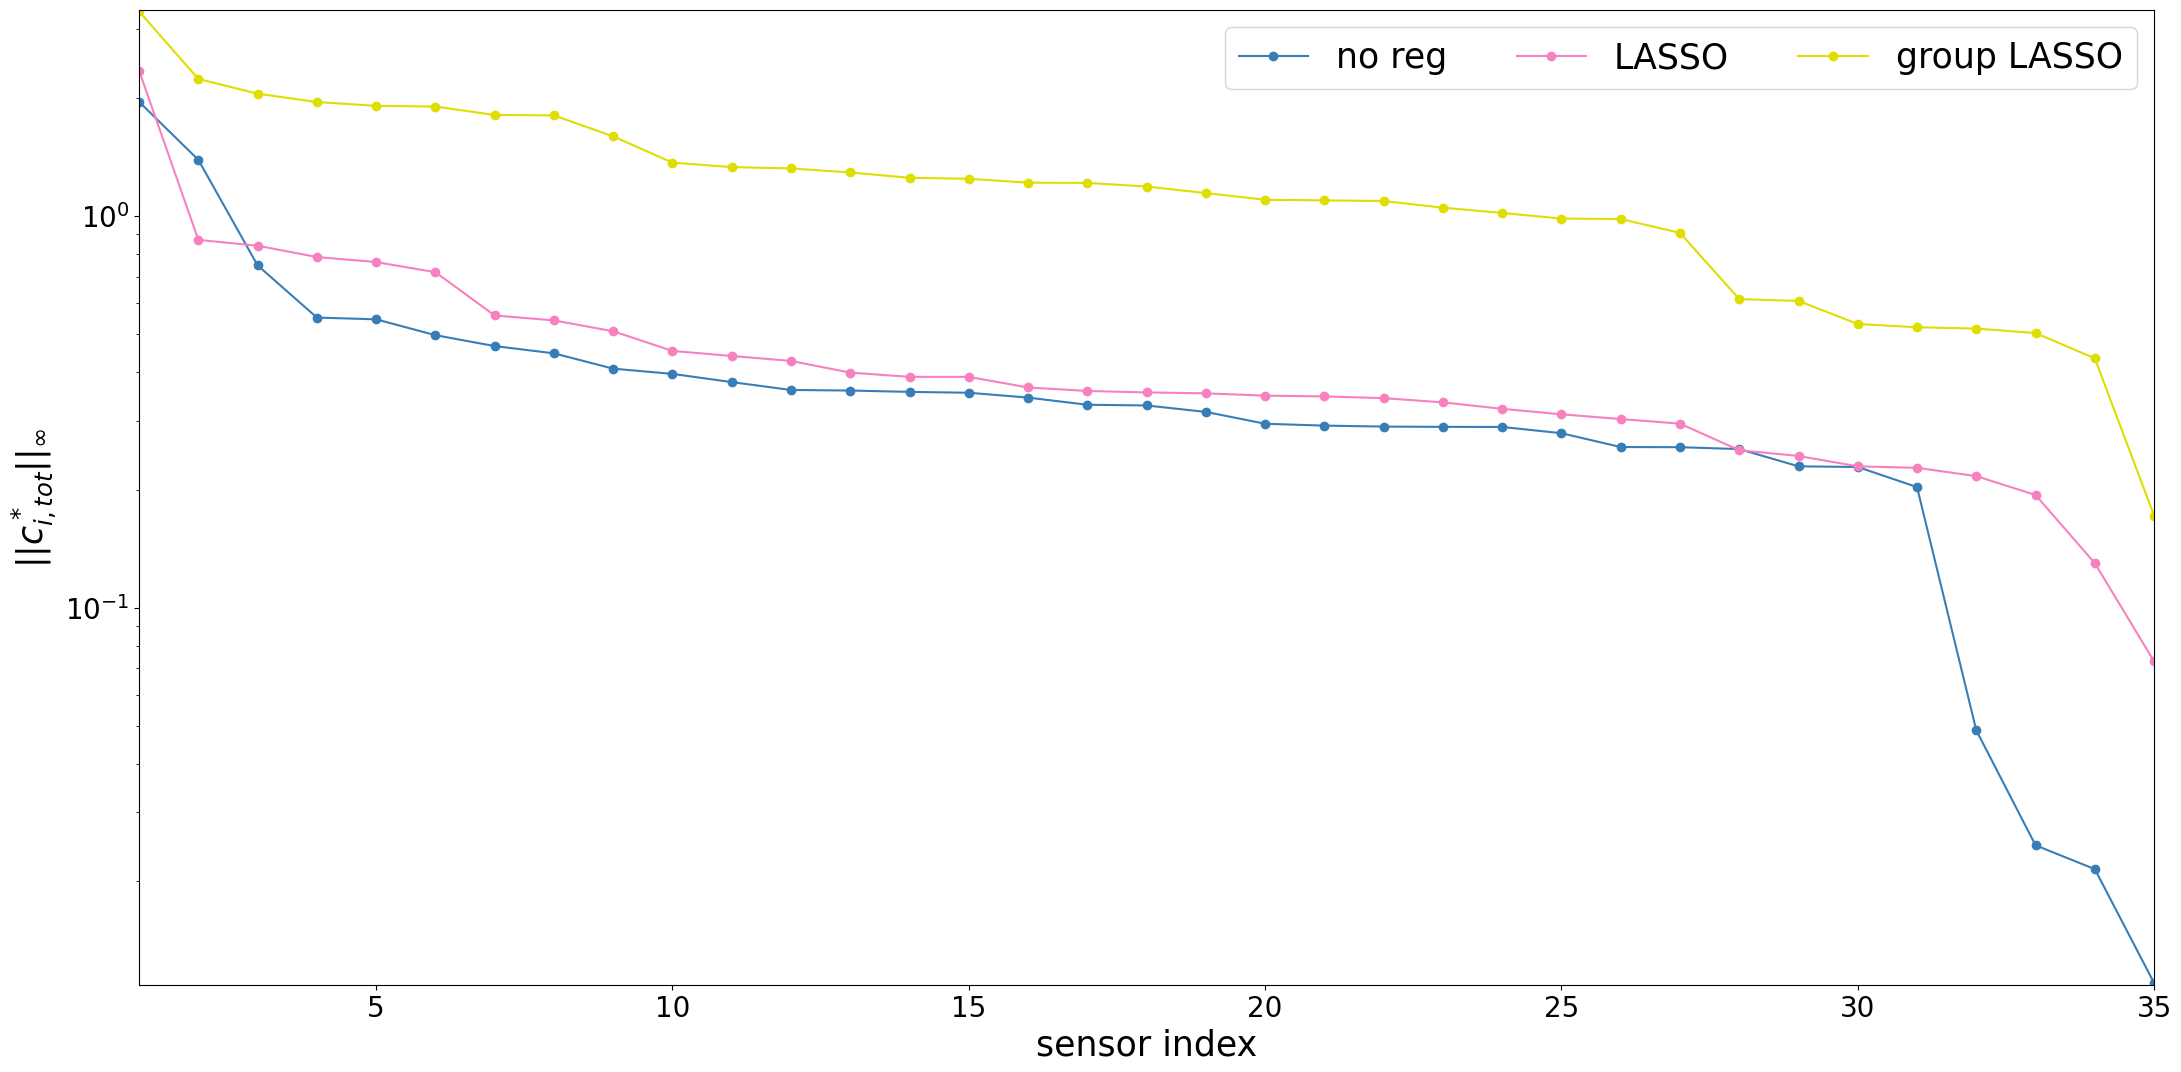

In [14]:
plot_mean_error_comparison_vs_t(
    msh, 
    dic,
    ctrl_target,
    #save_path=save_plot_path,
    #file_name='error_comp_reg', 
    #file_format='png', 
    #save_flag=True 
)
plot_mulitple_ctrl_multiple_t(
    msh,
    [0, 200],
    dic,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_a',
    figsize=(20, 20),
    n_ligne=1,
    #save_path=save_plot_path,
    #file_name='s_optim_reg_comp',
    #file_format='png',
)
plot_sls_comp(
    msh, 
    dic, 
    [0, 100, 200], 
    presence_threshold, 
    figsize=(20, 20), 
    #save_path=save_plot_path,
    #file_name='presence_prediction',
    #file_format='png',
)
plot_bump_chart(
    dic, 
    #save_plot_path = save_plot_path, 
    #name_file = 'mono_sensor_total_contrib_inf_norm', 
    #file_format = 'png'
)